### Load modules 

In [1]:
import sys
sys.path.insert(1, '../utils')
from metrics import *

import numpy as np
import tqdm
from matplotlib import style
from matplotlib import pyplot as plt
from numpy.linalg import solve
import pybobyqa
from sklearn.covariance import graphical_lasso

import pandas as pd
import regionmask
ar6_all = regionmask.defined_regions.ar6.all
style.use('seaborn')

### Load data

In [2]:
data = np.load('monthly_regional.npz')
regionTemp = data['regionTemp']

data = np.load('../forcing.npz')
forcing = data['forcing']

year = forcing[:,0].astype('int')
forcing = forcing[:,1]

nRegions, T, R = regionTemp.shape

### Inference functions

In [3]:
def getK(phi):
    K = np.zeros((T,T))
    K[0,0] = 1
    for col in range(1,T):
        K[0,col] = phi * K[0,col-1]
    for row in range(1,T):
        K[row,row:] = K[row-1, row-1:-1]
    K = K + K.T
    K[range(T),range(T)] = 1

    return K

def getX(rho):
    X = np.ones((T,3 + 2*nHarmonics))
    
    # Calculate the past trajectory of forcing for year 2006
    _coef = 1
    _traj = 0;
    for year in range(239,-1,-1): # forcing[239] is the forcing for 2004
        _traj += _coef * forcing[year]
        _coef *= rho
    _traj *= (1-rho)
    
    for month in range(T):
        year = month//12
        _year = year+241 # 241 is the index for year 2006 in forcing
        
        X[month,1] = forcing[_year] 
        
        if month%12 == 0: # Jan
            _traj = (1-rho) * forcing[_year-1] + rho * _traj

        X[month,2] = _traj
        
    for harmonic in range(nHarmonics):
        X[:, harmonic+3]            = np.cos( 2*np.pi * np.arange(0,T) / 12 * (harmonic+1) )
        X[:, harmonic+3+nHarmonics] = np.sin( 2*np.pi * np.arange(0,T) / 12 * (harmonic+1) )
        
    return X

def neg_llh(arg):
    rho, phi = arg
    value = np.log(1-phi*phi) * runsUsed * (T-1)
    
    # Build K
    K = getK(phi)
    
    # Build X
    X = getX(rho)
    
    Y = regionTemp[region,:,:runsUsed]
    Kiy = np.linalg.solve(K, Y)

    part1 = np.sum(Y * Kiy, axis = 0)
    part2 = X.T @ Kiy
    part2 = np.sum(part2 * np.linalg.solve(X.T @ np.linalg.solve(K,X), part2), axis = 0)

    value += np.sum(T * np.log(part1-part2))
    return value

### Get optimal number of harmonics

In [4]:
use_precomputed_results = True

In [5]:
BIC = np.zeros((nRegions, 5))
runsUsed = 35

if use_precomputed_results:
    BIC = np.load('results_BIC.npz')['BIC']
else:
    for nHarmonics in range(1,6):

        for region in tqdm.trange(58):

            res = pybobyqa.solve(neg_llh, x0 = [0.1, 0.9], 
                                 bounds = ([0.01, -0.99], [0.99, 0.99])
                                )

            rho, phi = res.x

            # Build K
            K = getK(phi)

            # Build X
            X = getX(rho)

            beta = (solve(X.T @ solve(K, X), X.T @ solve(K, regionTemp[region]))).mean(axis = 1)
            mean = X @ beta

            RSSmean = np.mean((mean - regionTemp[region].T) **2)

            BIC[region,nHarmonics-1] = np.log(T) * (2 + 2 * nHarmonics) + T * np.log(RSSmean)

    np.savez('results_BIC.npz', BIC = BIC)

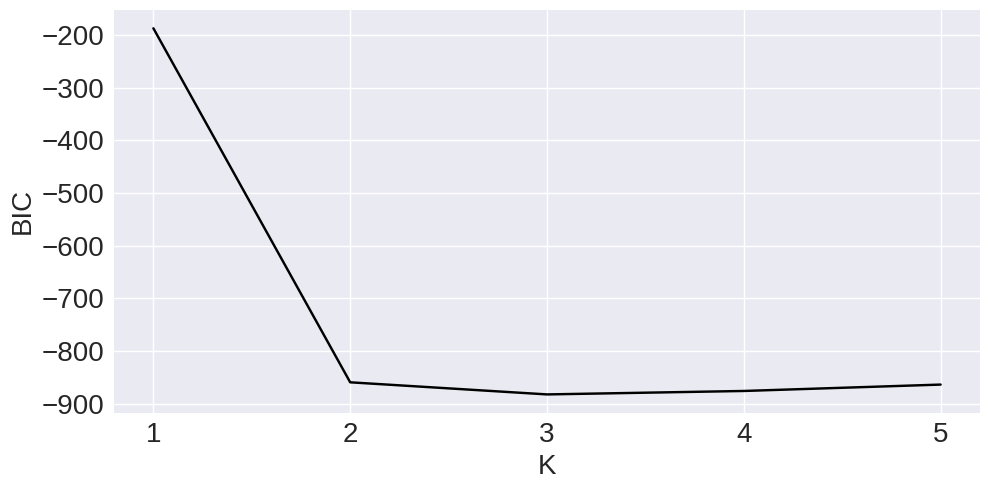

In [6]:
plt.figure(figsize = (10,5))
plt.plot(BIC.mean(axis = 0), 'k')
plt.xticks(range(5), np.arange(5)+1, fontsize = 20)
plt.xlabel('K', fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('BIC', fontsize = 20)

plt.tight_layout()
plt.savefig('SF6-BIC.pdf')

Conclusion: K = 3

In [7]:
nHarmonics = 3

### Model Inference

In [8]:
if use_precomputed_results:
    results = pd.read_csv('results_model3.csv', index_col=0)
else:
    results = pd.DataFrame(columns = ['rho', 'beta&a&b', 'phi', 'sigma', 'Ifit', 'nRuns', 'region'])
    for runsUsed in range(1,21):
        for region in range(58):

            index = f'{runsUsed}-{region}'

            res = pybobyqa.solve(neg_llh, x0 = [0.1, 0.9], 
                                 bounds = ([0.01, -0.99], [0.99, 0.99])
                                )

            rho, phi = res.x

            # Build K
            K = getK(phi)

            # Build X
            X = getX(rho)

            beta = (solve(X.T @ solve(K, X), X.T @ solve(K, regionTemp[region,:,:runsUsed]))).mean(axis = 1)

            mean = X @ beta
            epsilon = (regionTemp[region,:,:runsUsed].T - mean).T
            sigma = np.sqrt( (1 - phi * phi) * (solve(K, epsilon) * epsilon).sum() / T / runsUsed)

            results.loc[index] = [rho, beta, phi, sigma, None, runsUsed, ar6_all.abbrevs[region]]

            results.loc[index,'Ifit'] = get_I_fit(mean, regionTemp[region])
        
    results.to_csv('results_model3.csv')

### Graphical Lasso, penalty = 0.06

In [9]:
runsUsed = 6
nuSelect = np.zeros((nRegions, runsUsed, T))
record = results[results['nRuns']==runsUsed]

hatYmean = np.zeros((nRegions, T))

for region in range(58):

    # Build X
    X = getX(record.iloc[region]['rho'])

    beta = record.iloc[region]['beta&a&b']
    beta = beta.replace('[', '')
    beta = beta.replace(']', '')
    beta = np.array(beta.split(), dtype = 'float')

    phi = record.iloc[region]['phi']
    sigma = record.iloc[region]['sigma']

    hatYmean[region] = X @ beta

    epsilon = regionTemp[region,:,0:runsUsed].T - hatYmean[region]

    nuSelect[region,:,0]= epsilon[:,0]/sigma

    for t in range(1,T):
        nuSelect[region,:,t] = (epsilon[:,t] - epsilon[:,t-1] * phi)/sigma

C = np.cov(nuSelect.reshape(58,-1))

penalty = 0.06
Csparse, CsparseInv = graphical_lasso(C,penalty)
CsparseL = np.linalg.cholesky(Csparse)

print("{:.0f}% of entries in the sparse precision matrix generated by graphaical Lasso are zero".format(np.sum(CsparseInv == 0)/C.size*100))

75% of entries in the sparse precision matrix generated by graphaical Lasso are zero


In [10]:
if not use_precomputed_results:
    results['IUQ'] = np.nan
    for runsUsed in tqdm.trange(1,21):

        nu = np.zeros((nRegions, runsUsed, T))
        mean = np.zeros((nRegions, T))

        record = results[results['nRuns']==runsUsed]

        sigmaAllRegions = np.array(record['sigma'])
        phiAllRegions = np.array(record['phi'])

        for region in range(58):

            # Build X
            X = getX(record.iloc[region]['rho'])

            beta = record.iloc[region]['beta&a&b']
            beta = beta.replace('[', '')
            beta = beta.replace(']', '')
            beta = np.array(beta.split(), dtype = 'float')

            phi = record.iloc[region]['phi']
            sigma = record.iloc[region]['sigma']

            mean[region] = X @ beta

            epsilon = regionTemp[region,:,0:runsUsed].T - mean[region]

            nu[region,:,0]= epsilon[:,0]/sigma

            for t in range(1,T):
                nu[region,:,t] = (epsilon[:,t] - epsilon[:,t-1] * phi)/sigma

        C = np.cov(nu.reshape(58,-1))

        penalty = 0.06
        Csparse, _ = graphical_lasso(C, penalty)
        CsparseL_tmp = np.linalg.cholesky(Csparse)

        epsilon = np.empty((T, R, nRegions))
        tmp = CsparseL_tmp @ np.random.randn(nRegions, R)

        epsilon[0] = tmp.T * sigmaAllRegions

        for t in range(1,T):
            tmp = CsparseL_tmp @ np.random.randn(nRegions, R)

            epsilon[t] = tmp.T * sigmaAllRegions + epsilon[t-1] * phiAllRegions

        epsilon = np.moveaxis(epsilon, 0, 2)
        hatY = mean + epsilon # mean: nRegions * T, hatY: R * nRegions * T
        hatY = hatY.T # hatY: T * nRegions * R

        for region in range(nRegions):
            index = f'{runsUsed}-{region}'
            results.loc[index, 'IUQ'] = get_I_UQ(hatY[:,region], regionTemp[region])
            
    results.to_csv('results_model3_0.06.csv')

### Plot metric

In [11]:
Ifit = np.array(results['Ifit']).reshape(20,58)
IUQ = np.array(results['IUQ']).reshape(20,58)

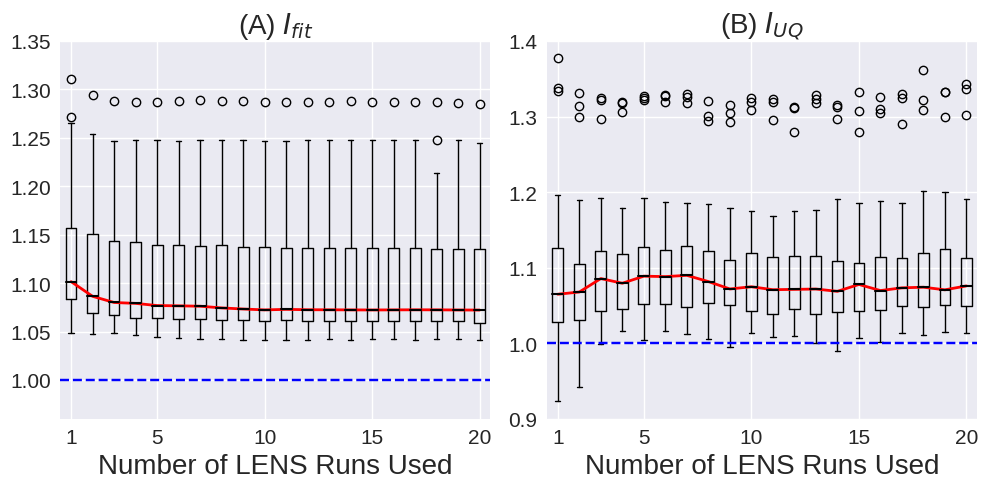

In [12]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.boxplot(Ifit.T,
            medianprops = dict(color="black",linewidth=1.5)
)
plt.plot(range(1,21), np.median(Ifit,axis = 1)[:20], linewidth = 2, color = 'red')
plt.axhline(1, color = 'blue', linestyle = '--')

plt.title('(A) $I_{fit}$', fontsize = 20)
plt.xlabel('Number of LENS Runs Used', fontsize = 20)
plt.xticks([1, *np.arange(5,25,5)], [1, *np.arange(5,25,5)], fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim(0.96,1.35)

plt.subplot(122)
plt.boxplot(IUQ.T,
           medianprops = dict(color="black",linewidth=1.5))
plt.plot(range(1,21), np.median(IUQ,axis = 1)[:20], linewidth = 2, color = 'red')

plt.axhline(1, color = 'blue', linestyle = '--')

plt.title('(B) $I_{UQ}$', fontsize = 20)
plt.xlabel('Number of LENS Runs Used', fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks([1, *np.arange(5,25,5)], [1, *np.arange(5,25,5)], fontsize = 15)
plt.ylim(0.9,1.4)

plt.tight_layout()
plt.savefig('SF7-region_monthly_metric.pdf', bbox_inches = 'tight')

## Report

### Generate 35 simulations

In [13]:
sigma = np.array(results[results.nRuns==6]['sigma'])
phi = np.array(results[results.nRuns==6]['phi'])
hatY = np.zeros((nRegions, T, R))
for r in tqdm.trange(R):

    epsilon = np.empty((nRegions, T))
    tmp = CsparseL @ np.random.randn(nRegions)

    for region in range(nRegions):
        epsilon[region,0] = tmp[region] * sigma[region]

    for t in range(1,T):
        tmp = CsparseL @ np.random.randn(nRegions)
        for region in range(nRegions):
            epsilon[region,t] = tmp[region] * sigma[region] + epsilon[region,t-1] * phi[region]

    hatY[:,:,r] = hatYmean + epsilon

100%|██████████| 35/35 [00:01<00:00, 19.14it/s]


In [14]:
CNA = 4
NAO = 50

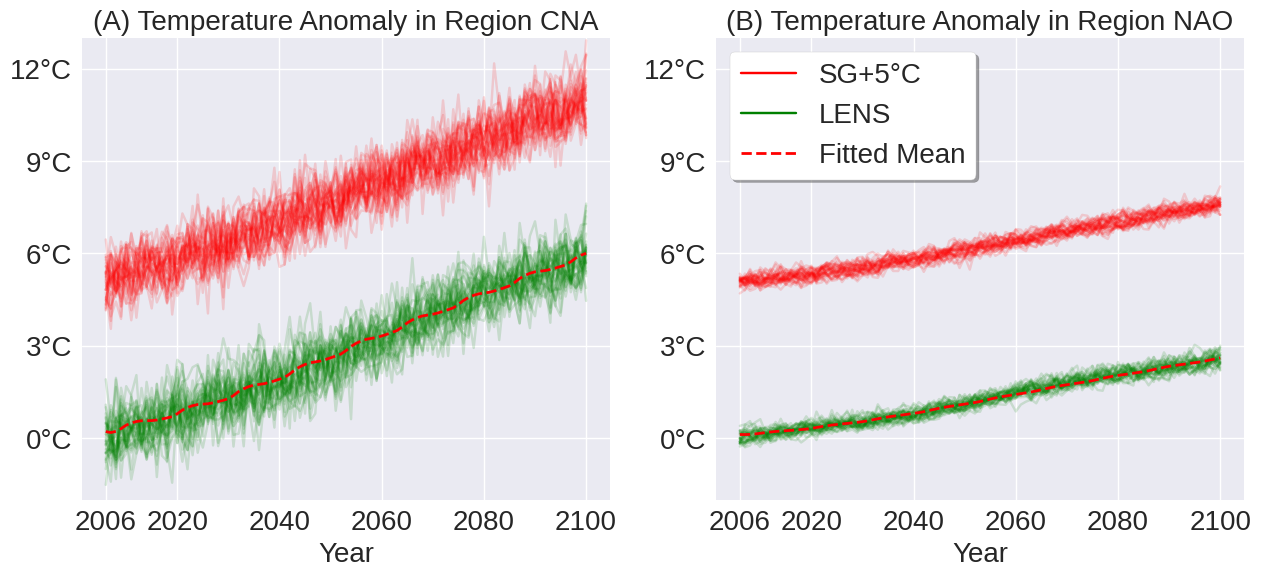

In [15]:
annualHatY = hatY.reshape(nRegions,-1,12,R).mean(axis = 2)
annualRegionTemp = regionTemp.reshape(nRegions,-1,12,R).mean(axis = 2)
annualHatYmean = hatYmean.reshape(nRegions,-1,12).mean(axis = 2)

fig = plt.figure(figsize=(15, 6))

ax = plt.subplot(121)

region = 4
TmeanStart = annualRegionTemp[region,0,:].mean()

plt.plot(range(2006,2101),annualHatY[region,:,0]+5-TmeanStart, color = 'red', label = 'SG+5\u00B0C', alpha = 0.15);

plt.plot(range(2006,2101), annualRegionTemp[region,:,0]-TmeanStart, color = 'green', label = 'LENS', alpha = 0.15);
plt.plot(range(2006,2101), annualRegionTemp[region,:,1:]-TmeanStart, color = 'green', alpha = 0.15);

plt.plot(range(2006,2101),annualHatY[region,:,1:]+5-TmeanStart, color = 'red', alpha = 0.15);

plt.plot(range(2006,2101),annualHatYmean[region]-TmeanStart,'r--', label = 'Fitted Mean', linewidth = 2)

plt.title(f'(A) Temperature Anomaly in Region {ar6_all.abbrevs[region]}',fontsize = 20)

plt.xticks([2006,*range(2020,2101,20)], fontsize = 20)
plt.xlabel('Year', fontsize = 20)
    
ax.yaxis.tick_left()
yticks = range(0,13,3)
plt.yticks(yticks, [u'{}\u00B0C'.format(x) for x in yticks], fontsize = 20)
plt.ylim(-2,13)


ax = plt.subplot(122)

region = 50
TmeanStart = annualRegionTemp[region,0,:].mean()

plt.plot(range(2006,2101),annualHatY[region,:,0]+5-TmeanStart, color = 'red', label = 'SG+5\u00B0C', alpha = 0.15);

plt.plot(range(2006,2101), annualRegionTemp[region,:,0]-TmeanStart, color = 'green', label = 'LENS', alpha = 0.15);
plt.plot(range(2006,2101), annualRegionTemp[region,:,1:]-TmeanStart, color = 'green', alpha = 0.15);

plt.plot(range(2006,2101),annualHatY[region,:,1:]+5-TmeanStart, color = 'red', alpha = 0.15);

plt.plot(range(2006,2101),annualHatYmean[region]-TmeanStart,'r--', label = 'Fitted Mean', linewidth = 2)

plt.title(f'(B) Temperature Anomaly in Region {ar6_all.abbrevs[region]}',fontsize = 20)

plt.xticks([2006,*range(2020,2101,20)], fontsize = 20)
plt.xlabel('Year', fontsize = 20)
    
ax.yaxis.tick_left()
yticks = range(0,13,3)
plt.yticks(yticks, [u'{}\u00B0C'.format(x) for x in yticks], fontsize = 20)
plt.ylim(-2,13)

leg = plt.legend(fontsize = 20, frameon = True, facecolor = 'white', 
                 shadow = True, fancybox = True, loc = 'upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
plt.savefig('SF9-regional-monthly-supp.pdf', bbox_inches='tight')

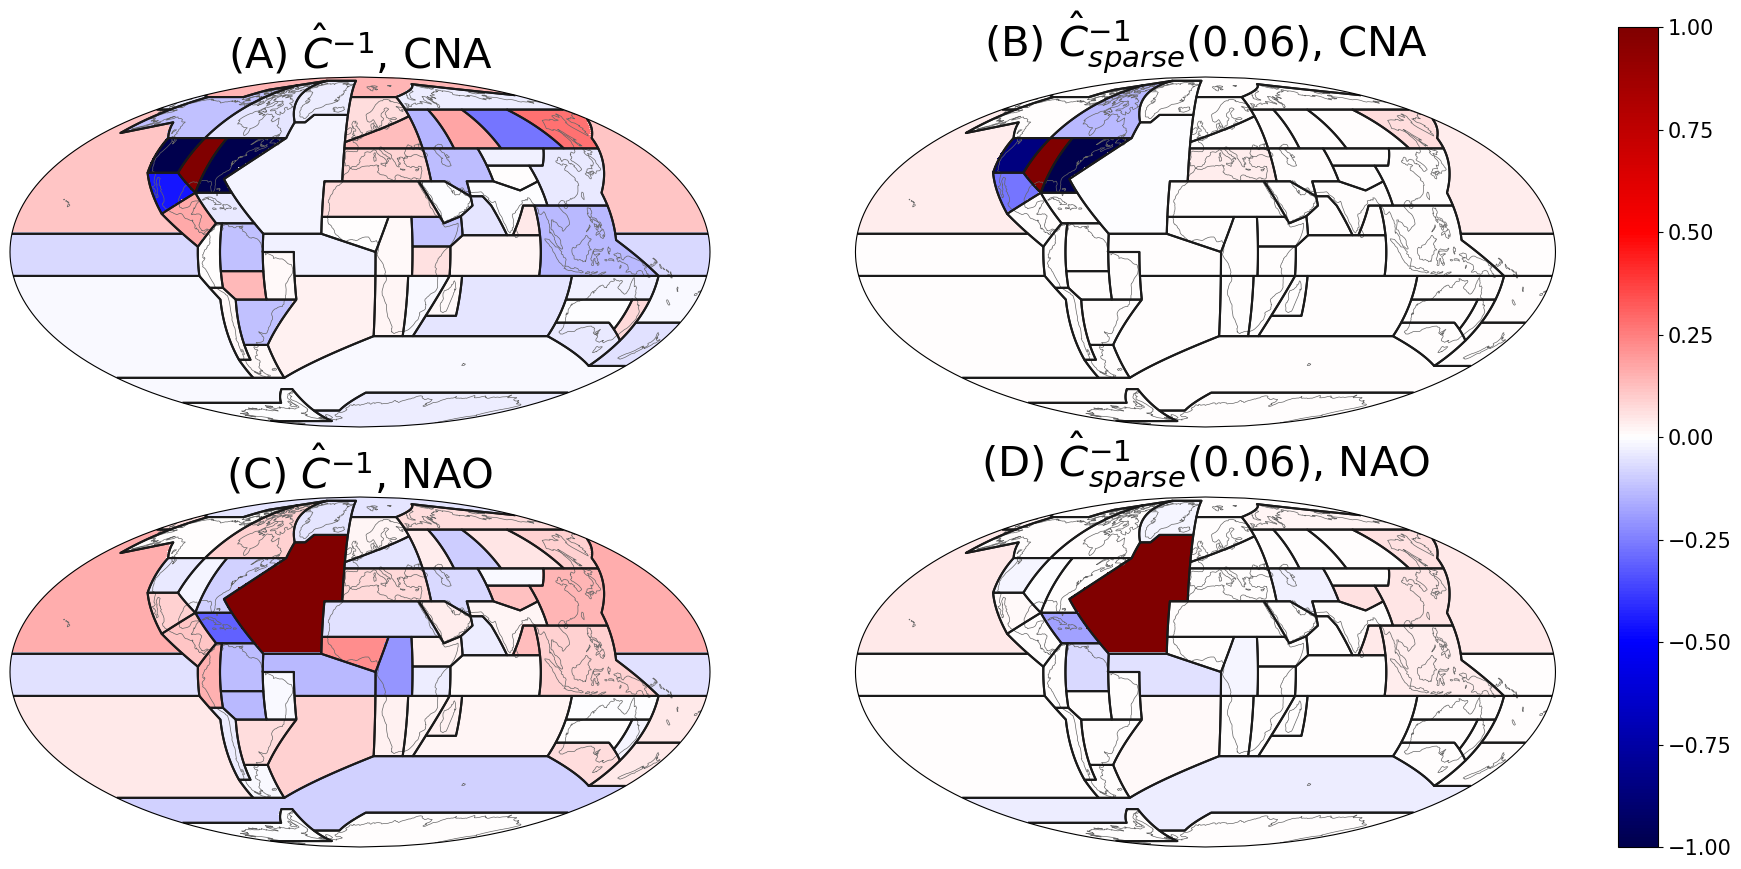

In [16]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

robinson = ccrs.Robinson(central_longitude=0)
geodetic = ccrs.Geodetic()
mollweide = ccrs.Mollweide(central_longitude=0)

lattice = regionmask.core.utils.create_lon_lat_dataarray_from_bounds(
    *(-180, 181, 1), *(90, -91, -1)
)

mask = ar6_all.mask(lattice)
showCNA, showCNASparse = np.zeros_like(mask), np.zeros_like(mask)
showNAO, showNAOSparse = np.zeros_like(mask), np.zeros_like(mask)

CInv = np.linalg.inv(C)
record = CInv[CNA]
recordSparse = CsparseInv[CNA]
for region in range(nRegions):
    showCNA[np.where(mask == region)] = record[region]
    showCNASparse[np.where(mask == region)] = recordSparse[region]
    
record = CInv[NAO]
recordSparse = CsparseInv[NAO]
for region in range(nRegions):
    showNAO[np.where(mask == region)] = record[region]
    showNAOSparse[np.where(mask == region)] = recordSparse[region]

style.use('default')

cm = plt.cm.seismic

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(2,2,1, projection=mollweide)

ax.coastlines(color='gray')
surface = ax.pcolormesh(lattice.LON, lattice.LAT, showCNA,
              transform=ccrs.PlateCarree(),cmap = cm, vmin = (-1,1))
plt.title('(A) $\hat C^{-1}$, CNA', fontsize = 30)

ar6_all.plot(add_label = False, ax = ax)

ax = fig.add_subplot(2,2,3, projection=mollweide)

ax.coastlines(color='gray')
surface = ax.pcolormesh(lattice.LON, lattice.LAT, showNAO,
              transform=ccrs.PlateCarree(),cmap = cm, vmin = (-1,1))

ar6_all.plot(add_label = False, ax = ax)
plt.title('(C) $\hat C^{-1}$, NAO', fontsize = 30)


ax = fig.add_subplot(2,2,2, projection=mollweide)

ax.coastlines(color='gray')
surface = ax.pcolormesh(lattice.LON, lattice.LAT, showCNASparse,
              transform=ccrs.PlateCarree(),cmap = cm, vmin = (-1,1))

plt.title('(B) $\hat C_{sparse}^{-1}(%.2f)$, CNA' % penalty, fontsize = 30)


ar6_all.plot(add_label = False, ax = ax)

ax = fig.add_subplot(2,2,4, projection=mollweide)

ax.coastlines(color='gray')
surface = ax.pcolormesh(lattice.LON, lattice.LAT, showNAOSparse,
              transform=ccrs.PlateCarree(),cmap = cm, vmin = (-1,1))


ar6_all.plot(add_label = False, ax = ax)
plt.title('(D) $\hat C_{sparse}^{-1}(%.2f)$, NAO' % penalty, fontsize = 30)

cb_ax = fig.add_axes([0.93, .11, .02, .82])
cbar = fig.colorbar(surface, cax=cb_ax)
cbar.ax.tick_params(labelsize=15) 

plt.savefig('SF8-monthly-reg-precision-ex.png', dpi = 150, bbox_inches='tight')

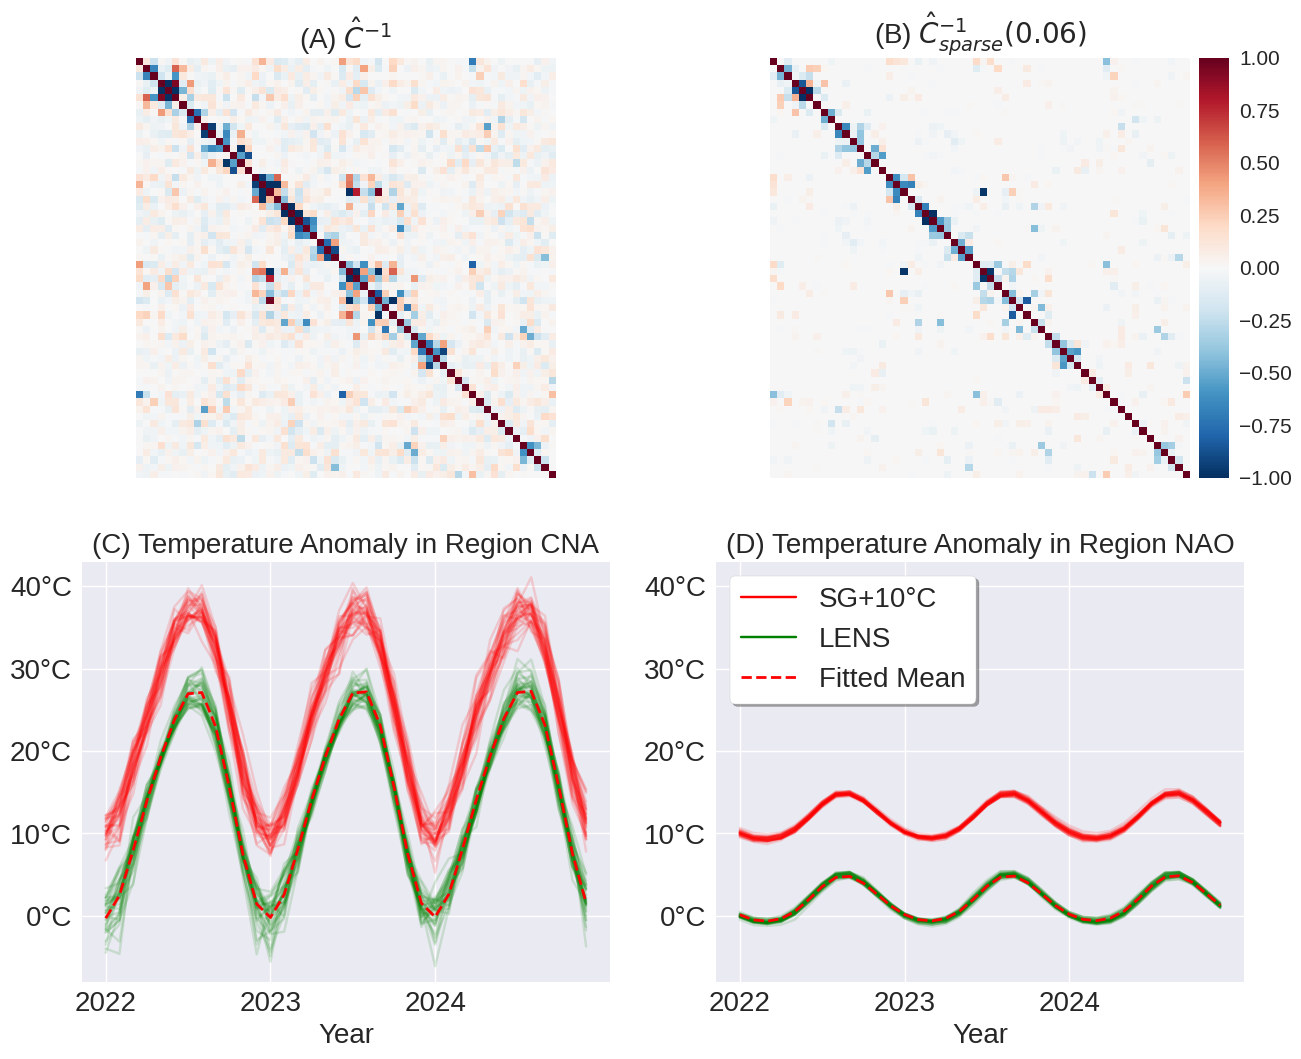

In [17]:
style.use('seaborn')

fig = plt.figure(figsize=(15, 12))

ax = plt.subplot(221)
ax.imshow(np.linalg.inv(C), cmap = plt.cm.RdBu_r, vmin = (-1,1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('(A) $\hatC^{-1}$', fontsize = 20)

ax = plt.subplot(222)
im = ax.imshow(CsparseInv, cmap = plt.cm.RdBu_r, vmin = (-1,1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('(B) $\hatC^{-1}_{sparse}(%.2f)$' % penalty, fontsize = 20)


cb_ax = fig.add_axes([.87, .53, .02, .35])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15) 

startYear = 2022
endYear = 2025
x = np.arange(startYear,endYear,1/12)
show = range(T-(endYear-startYear)*12,T)
offset = 10
ylim1 = (-8,43)
yticks1 = np.arange(0,50,10)

ax = plt.subplot(223)

region = 4
TmeanStart = regionTemp[region,show[0],:].mean()

plt.plot(x, (hatY[region,:,0]+offset-TmeanStart)[show], color = 'red', label = 'SG+{}\u00B0C'.format(offset), alpha = 0.15);

plt.plot(x, (regionTemp[region,:,0]-TmeanStart)[show], color = 'green', label = 'LENS', alpha = 0.15);
plt.plot(x, (regionTemp[region,:,1:]-TmeanStart)[show], color = 'green', alpha = 0.15);

plt.plot(x, (hatY[region,:,1:]+offset-TmeanStart)[show], color = 'red', alpha = 0.15);

plt.plot(x, (hatYmean[region]-TmeanStart)[show],'r--', label = 'Fitted Mean', linewidth = 2)

plt.title(f'(C) Temperature Anomaly in Region {ar6_all.abbrevs[region]}',fontsize = 20)

plt.xticks(range(startYear,endYear), fontsize = 20)
plt.xlabel('Year', fontsize = 20)
    
ax.yaxis.tick_left()
plt.yticks(yticks1, [u'{}\u00B0C'.format(x) for x in yticks1], fontsize = 20)
plt.ylim(*ylim1)

ax = plt.subplot(224)

region = 50
TmeanStart = regionTemp[region,show[0],:].mean()

plt.plot(x, (hatY[region,:,0]+offset-TmeanStart)[show], color = 'red', label = 'SG+{}\u00B0C'.format(offset), alpha = 0.15);

plt.plot(x, (regionTemp[region,:,0]-TmeanStart)[show], color = 'green', label = 'LENS', alpha = 0.15);
plt.plot(x, (regionTemp[region,:,1:]-TmeanStart)[show], color = 'green', alpha = 0.15);

plt.plot(x, (hatY[region,:,1:]+offset-TmeanStart)[show], color = 'red', alpha = 0.15);

plt.plot(x, (hatYmean[region]-TmeanStart)[show],'r--', label = 'Fitted Mean', linewidth = 2)

plt.title(f'(D) Temperature Anomaly in Region {ar6_all.abbrevs[region]}',fontsize = 20)

plt.xticks(range(startYear,endYear), fontsize = 20)
plt.xlabel('Year', fontsize = 20)

leg = plt.legend(fontsize = 20, frameon = True, facecolor = 'white', 
                 shadow = True, fancybox = True, loc = 'upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.yaxis.tick_left()
plt.yticks(yticks1, [u'{}\u00B0C'.format(x) for x in yticks1], fontsize = 20)
plt.ylim(*ylim1)

plt.savefig('F4-regional-monthly.pdf', bbox_inches='tight')